In [64]:
import pandas as pd
import sklearn as sk
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


First we open the tweets and take a look at them. We'll see that there are several columns that we don't want.

In [66]:
df_general_tweets = pd.read_csv('Tweets.csv')

In [67]:
df_general_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


We want to keep only the text and the labels so we're gonna create a new df with the columns that we want

In [68]:
df_prepared = pd.DataFrame().assign(Label=df_general_tweets['airline_sentiment'],Text=df_general_tweets['text'])

In [69]:
df_prepared.head()

,Label,Text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


This is an optional step but I'm gonna rename the columns to work more comfortably

In [70]:
df = df_prepared.rename(columns={'airline_sentiment':'label'})

In [71]:
df.head()

,Label,Text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


We're gonna explore the data using seabron. This will help us see if there are imbalance in the classes so we can be aware of this possibility as soon as possible. In order to do so we can make a graph that shows us the number of each type of tweet compared to the total number of tweets

<AxesSubplot: >

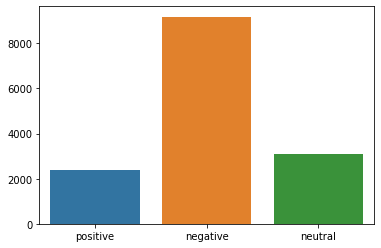

In [72]:
counts_dict = {'positive':[0],'negative':[0],'neutral':[0]}
for i in df['Label']:
    if i == "positive":
        counts_dict['positive'][0] +=1
    if i == "negative":
        counts_dict['negative'][0] +=1
    if i == "neutral":
        counts_dict['neutral'][0] +=1

#Exploring dataset:
df_plot = pd.DataFrame.from_dict(counts_dict)
sns.barplot(data=df_plot)

As we can see our classes are higly imbalanced, we have much more negative tweets than positives or neutrals so, maybe an ovr that compares class by class won't be the best choice.

Now I'm gonna preprocess the data to reduce dimensionality as well as see how well the model does. In case that we obtain poor results we could always change this function and try to prepare the data in a better way. For our case we tried both erasing only the punctuation as well as erasing the stopwords and we had a better result going for the simple. Remember that here there are a lot of preocess that we can do, lemmatize, change the tokenization, word to index mapping... etc

In [73]:
# import spacy
import string
# nlp = spacy.load("en_core_web_sm")


def normalize_text(raw_text):
    raw_text = str(raw_text).lower()
    text = raw_text.translate(str.maketrans('','',string.punctuation))
    # text = nlp(text)
    # final_token_list = [token for token in text if token.is_stop == False]
    # final_text_list = [token.text for token in final_token_list]
    # text_processed = " ".join(final_text_list)
    
    # return text_processed
    return text

In [74]:
df['Text'] = df['Text'].apply(lambda x: normalize_text(x))

Now our texts won't have any punctuation nor problematic and useless characters. Now it comes the moment to turn words into vectors. In order to vectorize is useful to try different strategies. In ur case we used both CountVectorizer as well as the TfIdf and the first one gave us better resutls so we just kept it.

In [75]:
vectorizer = CountVectorizer()
# vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df['Text'])
vectors.shape

(14640, 16632)

As always we divide out train and test sets

In [76]:
X_train, X_test, y_train, y_test = train_test_split(vectors, df['Label'], test_size=0.10, random_state=111)

Now, when it comes to use LogisticRegression for multiclassification tasks there are 2 possibilities. The ovr which goes class by class comparing with the other classes or the multinominal which goes directly with all the classes. Again the better way I think is to try both and check the results. About how to adjust the parameters there is tons of information in internet. In our case we used theses posts. 

https://www.kaggle.com/code/satishgunjal/multiclass-logistic-regression-using-sklearn/notebook
https://pub.towardsai.net/logistic-regression-for-multi-class-classification-hands-on-with-scikit-learn-bcc0bbad1def

In [77]:
from sklearn.linear_model import LogisticRegression

# model = LogisticRegression(multi_class='multinomial',solver='lbfgs', penalty='l2',max_iter=1000)
model = LogisticRegression(multi_class='ovr',solver='lbfgs',max_iter=1000)

While fitting the model you muight run into this error.

        ConvergenceWarning: lbfgs failed to converge (status=1):
        STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

        Increase the number of iterations (max_iter) or scale the data as shown in:
            https://scikit-learn.org/stable/modules/preprocessing.html
        Please also refer to the documentation for alternative solver options:
            https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
          n_iter_i = _check_optimize_result(

THis means that not all the vectors have been stored by a memory issue, but the best approximation possible is stored and that will be used. In order to solve it the best way is to increase the number of iterations. In our case to 1000 .
More information here.

https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter

In [78]:
def train(variable_with_model, vectors_of_training, labels_of_training):
    variable_with_model.fit(vectors_of_training, labels_of_training)

In [79]:
train(model,X_train,y_train)
pred = model.predict(X_test)

In [80]:
#Evaluate Logistic Regression model:
print("training set score: %f" % model.score(X_train, y_train))
print("test set score: %f" % model.score(X_test, y_test))
print("coefficients shape: ", model.coef_.shape)
print("intercept shape: ", model.intercept_.shape)

training set score: 0.933060
test set score: 0.824454
coefficients shape:  (3, 16632)
intercept shape:  (3,)


Well now is the time to interpret our results and make changes if needed. In our case tha classes were imbalanced so accuracy probably won't be a very good metric. Going by the book the F1_score is the most common so we're gonna go for it.

When working with f1_score with different classes we found this tutorial quite useful: https://www.baeldung.com/cs/multi-class-f1-score

Normally with the F1_score in a multiclassification problem we calculate the F1_score per class and, after that's done we can go to make calculations with the total of values fo the different classes.
In order to do so we can go by doing the following: 

we import the metric of f1_score and put the average parameter to 'None'. This way it will gave us back the f1 score as a list containing the values for all of the three classes. Remember that, in order to use the function we give as arguments the real values of test set as well as the predicted values.

In [81]:
from sklearn.metrics import f1_score
F1 = f1_score(y_test,pred,average=None)
print(F1)


[0.88745288 0.67192429 0.77803204]


We have a 0.82 aproximately. But, what if we want to have just a single number?, in that case we use these 3 values to make different averages. They will be exaplined in comments in the same cells

In [82]:
# micro calculates positive and negative values globally
F1 = f1_score(y_test,pred,average='micro')
print(F1)

0.8244535519125683


In [83]:
# macro, take the average of each class’s F-1 score
F1 = f1_score(y_test,pred,average='macro')
print(F1)
# Note that the macro method treats all classes as equal, independent of the sample sizes which is not ideal since we have imbalance classes.

0.7791364026083127


In [84]:
# The class F-1 scores are averaged by using the number of instances in a class as weights
F1 = f1_score(y_test,pred,average='weighted')
print(F1)

0.8221241034699063


As we can see there are different metrics that we can use. For our problem seems that weighted is the most adequate one since we have imbalanced classes but maybe your client wouldn't be happy with theses numbers so you will have to ask for a more balanced datasets, or change the preprocess or even the algorithm that you're using. The metrics only gave us numbers, is up to the project requirements as well as the Data science team to evaluate and take the decisions needed for the problem at hand.